# Assignment
______________

## Workflow
 ===========

#### 1. Problem Statement and Dataset Description and Loading Dataset
#### 2. Task 1: Data cleaning and check the distribution of gene expression across samples 
#### 3. Task 2: Identify only the ​Exocrine​ (adenocarcinoma) tumors and remove ​Neuroendocrine​ tumors.  
#### 4. Task 3: ​Understand the effect of Interferons in Pancreatic Adenocarcinoma.


. . . . 

In [2]:
import warnings
warnings.filterwarnings("ignore")

# importing libraries
import pandas as pd
import numpy as np
from cmapPy.pandasGEXpress.parse import parse
import seaborn as sn

from GSVA import gsva, gmt_to_dataframe
# Some extras to look at the high dimensional data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import pylab 
import scipy.stats as stats
import scipy.cluster.hierarchy as shc

##  1. Problem Statement and Dataset Description and Loading Dataset

Pancreatic Adenocarcinoma (PAAD) is the third most common cause of death from cancer, with an overall 5-year survival rate of less than 5%, and is predicted to become the second leading cause of                  cancer mortality in the United States by 2030

### 1.1 Dataset Description

##### Dataset source: https://github.com/cit-bioinfo/TCGA_PAAD_survival


* RNA-Seq (RNA sequencing), is a sequencing technique to detect the quantity of RNA in a biological sample at a given moment. 

* Here we have a dataset of normalized RNA Sequencing reads for pancreatic cancer tumors​. The measurement consists of ~20,000 genes for 185 pancreatic cancer tumors.

* The file format is GCT , a tab-delimited file used for sharing gene expression data and metadata (details for each sample) for samples

### 1.2 Loading Dataset

In [3]:
# Dataset source: https://github.com/cit-bioinfo/TCGA_PAAD_survival

# Interferons data
IFN_data = pd.read_csv('type1_IFN.txt',sep=" ", header = None) 

# TCGA pancreatic adenocarcinoma dataset.
PAAD_data = parse("PAAD.gct") 

### 1.3 Overview of dataset

In [4]:
# Shape of data
print(f'shape of data: {PAAD_data.data_df.shape}\n')

shape of data: (18465, 183)



In [5]:
print(f"Shape of col_metadata_df: {PAAD_data.col_metadata_df.shape}\n")

print("Sample:")
PAAD_data.col_metadata_df.head(2)

Shape of col_metadata_df: (183, 124)

Sample:


chd,participant_id,sample_type,mRNAseq_cluster,bcr_patient_barcode,bcr_patient_uuid,vital_status,days_to_death,days_to_last_followup,additional_studies,adenocarcinoma_invasion,...,tobacco_smoking_history,total_dose,total_dose_units,tumor_tissue_site,tumor_type,withdrawn,year_of_dcc_upload,year_of_form_completion,year_of_initial_pathologic_diagnosis,year_of_tobacco_smoking_onset
cid,,,,,,,,,,,,,,,,,,,,,
aab1-Primary solid Tumor,aab1,Primary solid Tumor,1.0,tcga-2j-aab1,75119d1a-93e5-4ae7-9d60-69ee929a0772,dead,66.0,NaN,NaN,yes,...,3.0,NaN,NaN,pancreas,primary,false,2016,2014,2012.0,1962.0
aab4-Primary solid Tumor,aab4,Primary solid Tumor,2.0,tcga-2j-aab4,33833131-1482-42d5-9cf5-01cade540234,alive,NaN,729.0,NaN,yes,...,5.0,NaN,NaN,pancreas,primary,false,2016,2014,2012.0,NaN


In [6]:
print(f"Shape of row_metadata_df: {PAAD_data.row_metadata_df.shape}\n")

print("Sample:")
PAAD_data.row_metadata_df.head(5)

Shape of row_metadata_df: (18465, 0)

Sample:


rhd
rid
SLC35E2
A1BG
A1CF
A2BP1
A2LD1


In [7]:
# metadata about samples
meta_data_column = PAAD_data.col_metadata_df.columns 

# names of GENE seq 
meta_data_row = PAAD_data.row_metadata_df.index 

# gene_dataframe
gene_dataframe = PAAD_data.data_df
gene_dataframe.sample(3)

cid,aab1-Primary solid Tumor,aab4-Primary solid Tumor,aab6-Primary solid Tumor,aab8-Primary solid Tumor,aab9-Primary solid Tumor,aaba-Primary solid Tumor,aabe-Primary solid Tumor,aabf-Primary solid Tumor,aabh-Primary solid Tumor,aabi-Primary solid Tumor,...,aauh-Primary solid Tumor,aaui-Primary solid Tumor,aaul-Primary solid Tumor,a8t3-Primary solid Tumor,a8t5-Primary solid Tumor,a89d-Solid Tissue Normal,a89d-Primary solid Tumor,a8sy-Primary solid Tumor,a8lh-Primary solid Tumor,aapl-Primary solid Tumor
rid,,,,,,,,,,,,,,,,,,,,,
NOXO1,8.1,3.6,5.8,6.2,3.3,8.6,8.8,6.1,5.6,6.2,...,2.4,4.5,7.3,2.7,5.0,4.3,6.5,6.8,9.0,6.5
PRKAA1,11.0,10.8,10.2,11.0,10.4,11.5,11.1,11.3,10.9,9.8,...,10.7,10.5,11.0,10.7,10.9,10.6,11.2,10.4,11.0,11.2
LZIC,7.8,8.2,8.5,8.1,7.9,7.1,8.0,8.4,7.7,7.4,...,8.2,7.7,7.7,8.1,8.0,7.9,8.2,7.8,7.7,7.9


## 2. Task 1:  Data cleaning and check the distribution of gene expression across samples

2.1. Remove genes with NaNs. How many genes had NaNs? 

2.2. Generate gene expression distribution for all samples. How is the distribution of gene expression across samples?

### 2.1 Remove genes with NaNs. How many genes had NaNs?

In [8]:
# Number of genes containing null values
genes_having_null_val = sum(gene_dataframe.T.isnull().any())
print(f'Number of genes containing null values: {genes_having_null_val}')

Number of genes containing null values: 4367


In [9]:
# Removing genes with NaN's
droped_gene_data = gene_dataframe.T.dropna(axis=1,how='any').T
print(f"\nshape of gene dataframe aftre dropping the genes having null values: {droped_gene_data.shape}")


shape of gene dataframe aftre dropping the genes having null values: (14098, 183)


In [10]:
# Gene remain after removing the genes conaining null values
gene_data_remain = (gene_dataframe.T.shape[1] - genes_having_null_val)/gene_dataframe.T.shape[0]
print(f" percentage of genes remain after removing the genes conaining null values : {round(gene_data_remain,2)} %")

 percentage of genes remain after removing the genes conaining null values : 77.04 %


### 2.2  Generate gene expression distribution for all samples. How is the distribution of gene expression across samples?

#### 2.2.1. Generate gene expression distribution for all samples

100%|███████████████████████████████████████████████████████████████████████████████| 183/183 [00:01<00:00, 125.68it/s]


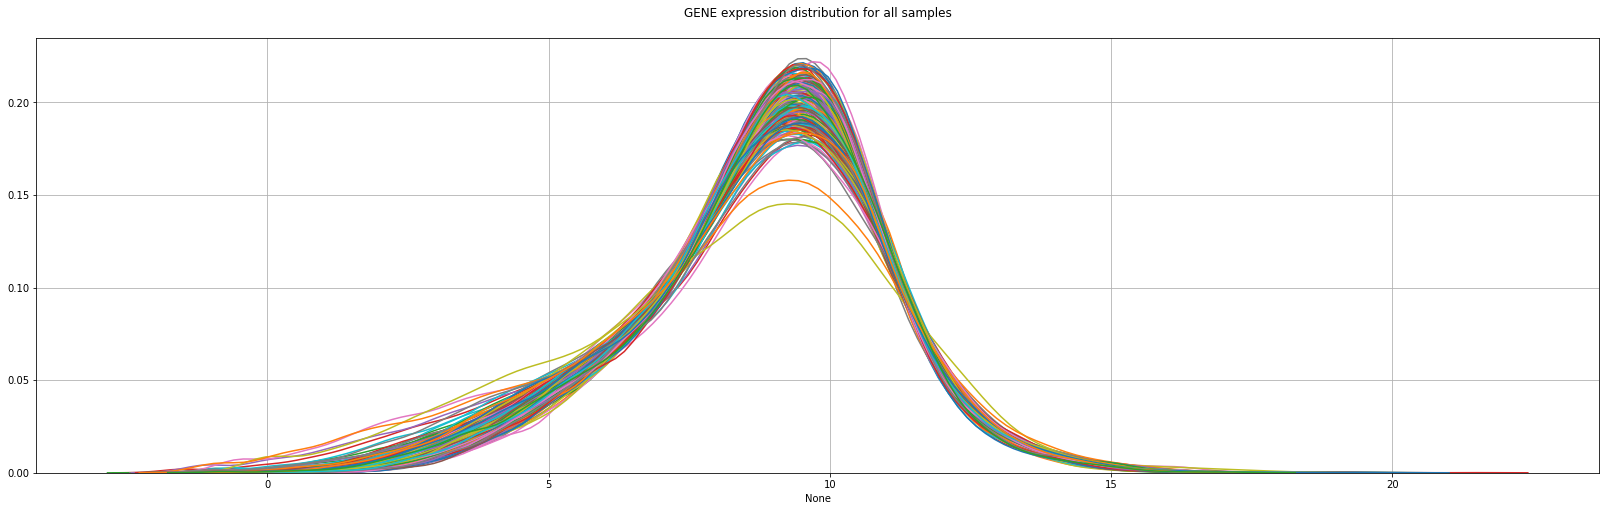

In [191]:
# Distribution plt
plt.figure(figsize=(28,8))
for sample_name in tqdm(list(droped_gene_data.columns)):
    sn.distplot(droped_gene_data.loc[:,sample_name],hist=False)
plt.title("GENE expression distribution for all samples\n")
plt.xlabel("None")
plt.grid()
plt.show()

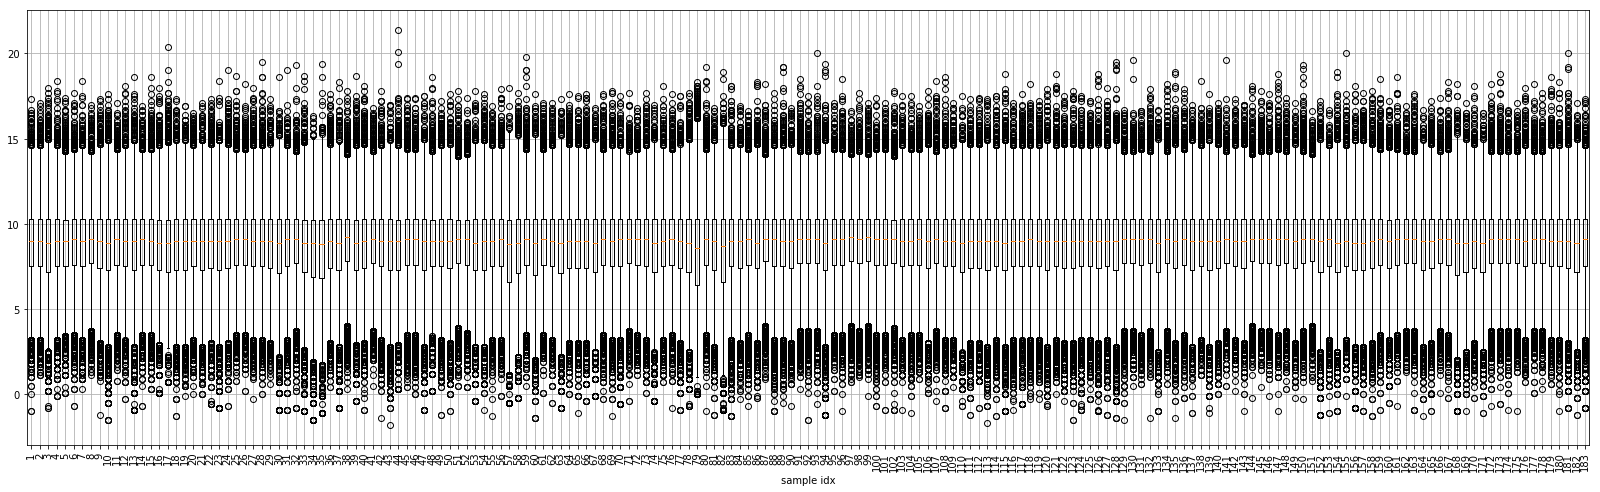

In [16]:
# Box Plot
plt.figure(figsize=(28,8))
plt.boxplot(droped_gene_data.T,)
plt.xticks(rotation = 90)
plt.xlabel("sample idx")
plt.grid()
plt.show()

#### 2.2.2. How is the distribution of gene expression across samples?

##### Observation on above plots:
1. It looks like distribution of gene follows Normal distribution.
2. Almost all the gene expression having same distribution across all the samples.

##### To make sure if distribution follows gaussian distribution or not, let's use some statistical analyses.

#### 2.2.2.1  Q-Q Plot to make sure if distribution follows gaussian distribution

100%|███████████████████████████████████████████████████████████████████████████████| 183/183 [00:01<00:00, 107.77it/s]


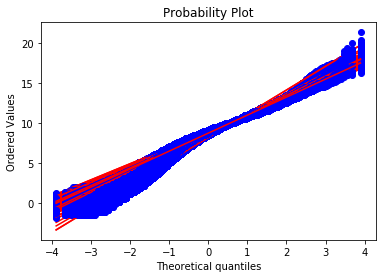

In [10]:
for sample_name in tqdm(list(droped_gene_data.columns)):
    measurements = droped_gene_data.loc[:,sample_name]
    stats.probplot(measurements, dist="norm", plot=pylab,)
pylab.show()

##### Observation:
* Looking at above Q-Q plots for dies disrtribution across all samples, It do looks like that distribution roughly follows gaussian distribution with variability in some samples.
* We can say that genes data across all samples are differentially expressed.

## 3. Task 2: Identify only the ​Exocrine​ (adenocarcinoma) tumors and remove ​Neuroendocrine​ tumors.

We want to stratify these tumor samples by the type of pancreatic cancer they exhibit. For this, apply dimensionality reduction techniques (PCA) to find these two groups within this multi-dimensional data.  
 
● Visualize the data whole data using PCA. 

● What does the analysis say about the general behaviour of the different samples? 

● Are the neuroendocrine tumors clearly separable from the adenocarcinoma tumors? -Overlay the information from metadata column ‘histological_type_other’ on top of PCA plot and check if neuroendocrine tumors are separating out. 

● What can be said about the variance of the PCA? 

● Remove the neuroendocrine tumors from the dataset so that it contains only the adenocarcinoma tumor samples. The histology for the different tumor samples is contained in the GCT file. 
 

### 3.1 Visualize the data whole data using PCA.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scaling mean = 0, var = 1
standard_droped_gene_data = pd.DataFrame(StandardScaler().fit_transform(droped_gene_data), 
                           index = droped_gene_data.index,
                           columns = droped_gene_data.columns)

# Pca transformation to only top 2 dim
pca = PCA(n_components=2, random_state=1234)
pca_transformed_genes = pca.fit_transform(standard_droped_gene_data.T)

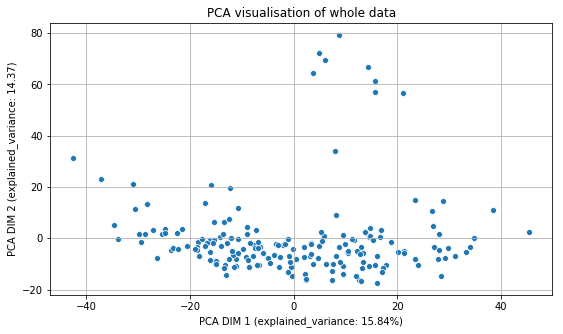

In [14]:
# Visualisation of whole data Using PCA

plt.figure(figsize=(9,5))
sn.scatterplot(pca_transformed_genes[:,0],pca_transformed_genes[:,1])
plt.title("PCA visualisation of whole data")
plt.xlabel(f"PCA DIM 1 (explained_variance: {round(pca.explained_variance_ratio_[0]*100,2)}%)")
plt.ylabel(f"PCA DIM 2 (explained_variance: {round(pca.explained_variance_ratio_[1]*100,2)})")
plt.grid()

### 3.2  What does the analysis say about the general behaviour of the different samples?

##### Observation:


* There is definately some randomness in the plot but sill we can see bunch of samples on top part of plot is seperated from rest of the samples.

### 3.3 Are the neuroendocrine tumors clearly separable from the adenocarcinoma tumors? 
Overlay the information from metadata column ‘histological_type_other’ on top of PCA plot and check if neuroendocrine tumors are separating out.

In [15]:
# getting the information of 'histological_type_other' from metadata column of PAAD_data
histological_type_other = PAAD_data.col_metadata_df['histological_type_other']

# Values count of histological_type_other
histological_type_other.value_counts(dropna=False)

NaN                                                                         156
adenocarcinoma, nos                                                           8
neuroendocrine carcinoma nos                                                  5
invasive adenocarcinoma                                                       2
poorly differentiated pancreatic adenocarcinoma                               2
moderately differentiated ductal adenocarcinoma 60% + neuroendocrine 40%      1
neuroendocrine carcinoma                                                      1
ductal and micropapillary                                                     1
intraductal tubulopapillary neoplasm                                          1
not specified                                                                 1
invasive, well-differentiated                                                 1
adenocarcinoma- nos                                                           1
neuroendocrine                          

##### Note: There are large amount of samples where histological_type_other has NaN values, it may inpact the PCA visualisation.

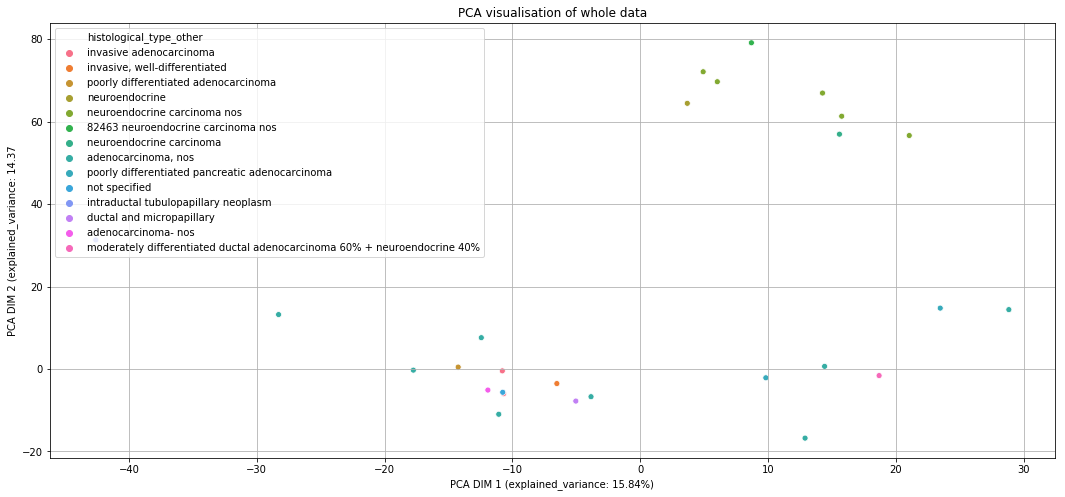

In [16]:
# Visualisation of whole data Using PCA
plt.figure(figsize=(18,8))
sn.scatterplot(x = pca_transformed_genes[:,0], y = pca_transformed_genes[:,1], hue = histological_type_other)
plt.title("PCA visualisation of whole data")
plt.xlabel(f"PCA DIM 1 (explained_variance: {round(pca.explained_variance_ratio_[0]*100,2)}%)")
plt.ylabel(f"PCA DIM 2 (explained_variance: {round(pca.explained_variance_ratio_[1]*100,2)}")
plt.legend()
plt.grid()

##### Observation:


* Overlay the information from metadata column 'histological_type_other' on top of PCA are able to show rougly 3 groups
* Group 1 which is on the top of plot indicating sample with neuroendocrine tumor.

### 3.4 What can be said about the variance of the PCA?

##### Vaiance of PCA tells that how much percentage of total sample can be explained using each eigen vector of PCA.. 

In [17]:
print(f"First PCA dim has explained_variance of {round(pca.explained_variance_ratio_[0]*100,2)} %  ")
print(f"Second PCA dim has explained_variance of {round(pca.explained_variance_ratio_[1]*100,2)} % \n")
print(f"Top  2 PCA dim can explain {round(pca.explained_variance_ratio_[0]*100+pca.explained_variance_ratio_[1]*100,2)}% of total sample distribution \n{'-'*62}")

First PCA dim has explained_variance of 15.84 %  
Second PCA dim has explained_variance of 14.37 % 

Top  2 PCA dim can explain 30.2% of total sample distribution 
--------------------------------------------------------------


### 3.5.Remove the neuroendocrine tumors from the dataset so that it contains only the adenocarcinoma tumor samples.
The histology for the different tumor samples is contained in the GCT file.

In [18]:
# finding the names in histological_type_other contaning neuroendocrine
col_containing_neuroendocrine = [col_name for col_name in PAAD_data.col_metadata_df['histological_type_other'].unique() if "neuroendocrine" in str(col_name) ]

# Finding the sample name contains only the adenocarcinoma tumor samples(Remove the neuroendocrine tumors from the dataset)
sample_names_having_no_neuroendocrine = []
for name in col_containing_neuroendocrine:
    sample_names_having_no_neuroendocrine.extend(list(PAAD_data.col_metadata_df[PAAD_data.col_metadata_df['histological_type_other'] ==name].index))
    
# Gene seq for ony those samples where adenocarcinoma tumor is present
sample_containing_only_adenocarcinoma = droped_gene_data.T.loc[[col for col in droped_gene_data.columns if col not in sample_names_having_no_neuroendocrine]].T

print(f"Shape of gene data after removing neuroendocrine tumors from the dataset: {sample_containing_only_adenocarcinoma.shape}")
print(f"Number of samples removed: { len(sample_names_having_no_neuroendocrine)} ({round(len(sample_names_having_no_neuroendocrine)/len(droped_gene_data.columns),2)} %)")

Shape of gene data after removing neuroendocrine tumors from the dataset: (14098, 174)
Number of samples removed: 9 (0.05 %)


In [19]:
# Dataset conating only adenocarcinoma tumor 
sample_containing_only_adenocarcinoma.sample(2)

cid,aab1-Primary solid Tumor,aab4-Primary solid Tumor,aab6-Primary solid Tumor,aab8-Primary solid Tumor,aab9-Primary solid Tumor,aaba-Primary solid Tumor,aabe-Primary solid Tumor,aabf-Primary solid Tumor,aabh-Primary solid Tumor,aabi-Primary solid Tumor,...,aaug-Primary solid Tumor,aauh-Primary solid Tumor,aaui-Primary solid Tumor,aaul-Primary solid Tumor,a8t3-Primary solid Tumor,a89d-Solid Tissue Normal,a89d-Primary solid Tumor,a8sy-Primary solid Tumor,a8lh-Primary solid Tumor,aapl-Primary solid Tumor
rid,,,,,,,,,,,,,,,,,,,,,
GOLPH3L,10.4,9.8,10.2,10.7,9.7,10.0,10.2,10.3,10.6,9.8,...,9.4,9.6,9.9,9.8,9.2,9.0,9.5,9.5,10.8,9.4
BMI1,10.0,9.8,10.4,10.1,10.5,10.3,10.5,10.2,9.6,8.9,...,10.4,10.6,10.0,10.6,10.2,10.0,10.3,10.4,10.9,10.5


### 3.6 Further Analyses on clustering of samples besed on genes seq (Optional!)

#### 3.6.1 Hierarchy clustering on top PCA Transformed feature 

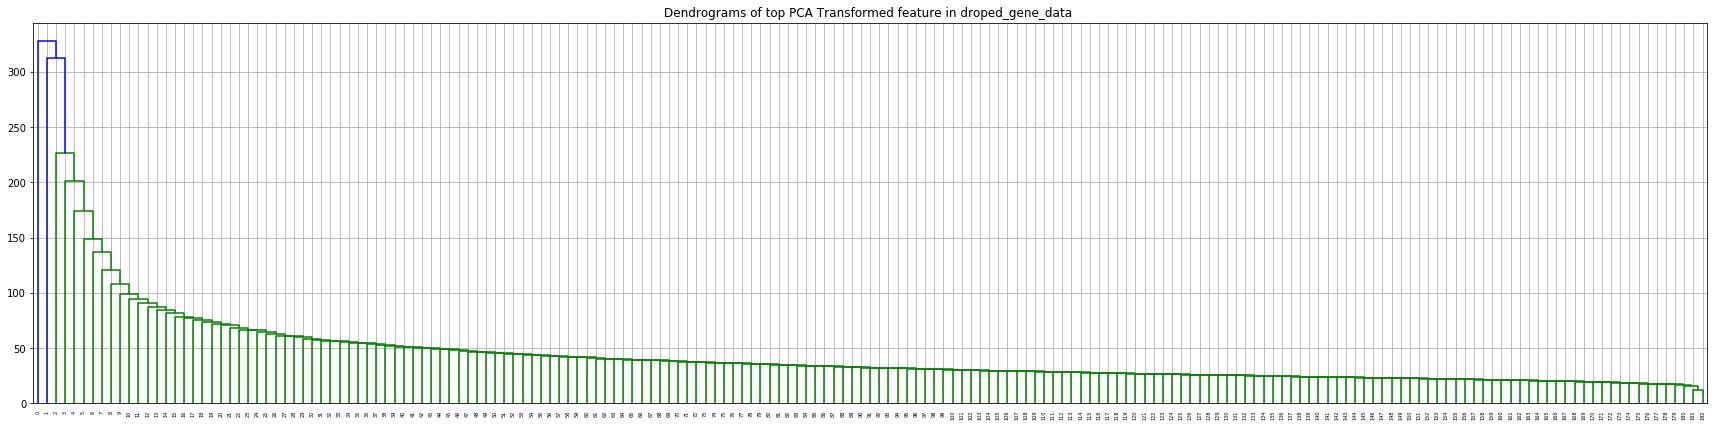

In [281]:
# hierarchy clustering on top PCA Transformed feature 
# Refer: https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/

import scipy.cluster.hierarchy as shc

# Pca transformation  across all gene feature
pca = PCA( random_state=1234)
pca_transformed_genes = pca.fit_transform(standard_droped_gene_data.T)

plt.figure(figsize=(30, 7))  
plt.title("Dendrograms of top PCA Transformed feature in droped_gene_data ")  
dend = shc.dendrogram(shc.linkage(pca_transformed_genes.T, method='ward'))
plt.grid()
plt.show()

#### 3.6.2 Hierarchy clustering on top PCA Transformed feature with heatmap

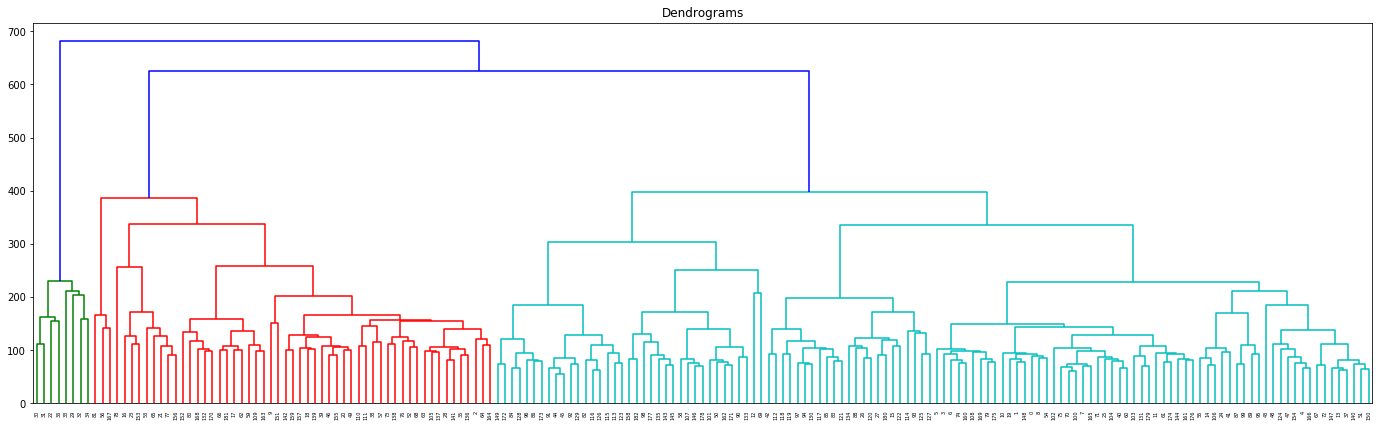

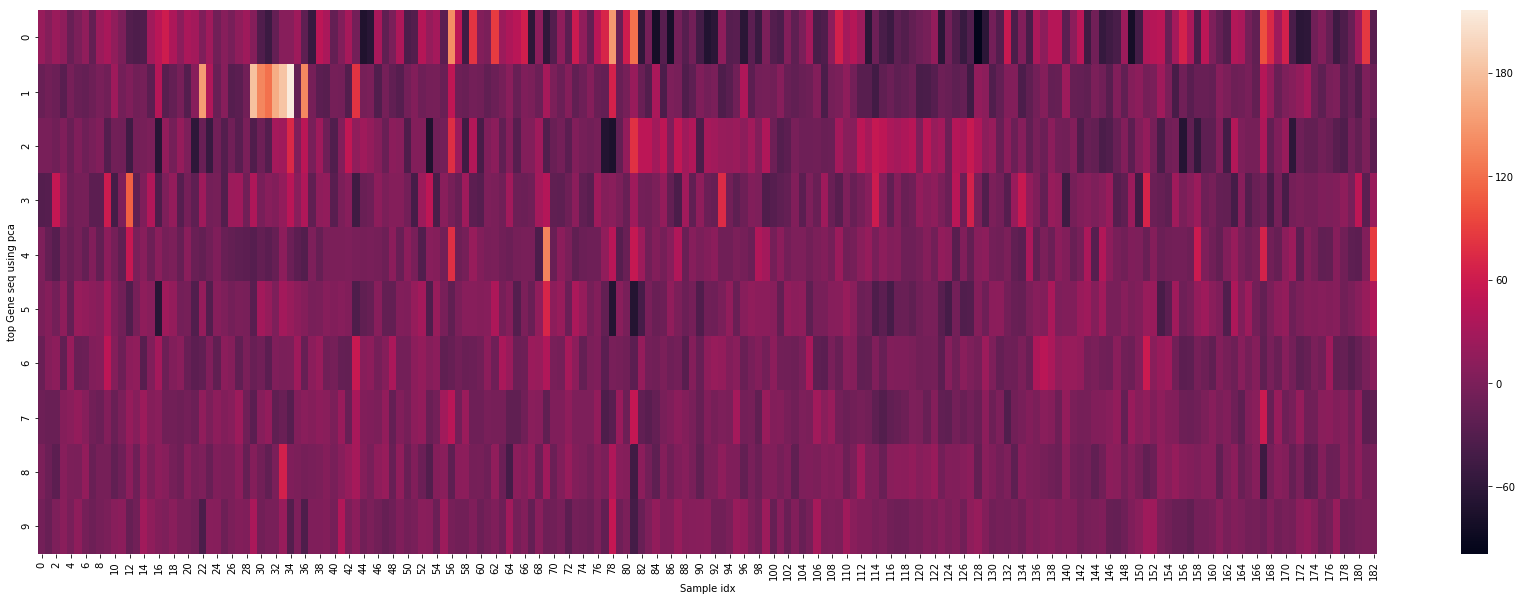

In [247]:
# hierarchy clustering on PCA Transformed feature with heatmap

# plot for Dendogram
plt.figure(figsize=(24, 7))  
plt.title("Dendrograms of PCA Transformed Feature With Heatmap")  
dend = shc.dendrogram(shc.linkage(pca_transformed_genes, method='ward'))
plt.show()

# Plot for Heatmap
plt.figure(figsize=(30,10))
sn.heatmap(pca_transformed_genes[:,:10].T)
plt.xlabel("Sample idx")
plt.ylabel("top Gene seq using pca")
plt.show()

##### Observation:


1. Hierarchy clustering is able to group the samples into two groups.
2. Heatmap of top PCA transformed feature is also showing some difference in different samples.

## 4. Task 3: ​Understand the effect of Interferons in Pancreatic Adenocarcinoma.


● Can you plot the gene expression values for these genes for pancreatic adenocarcinoma? 

● Run the GSVA (a single sample gene set enrichment) algorithm with 25 gene IFN signature as the gene set and the subsetted pancreatic cancer data as the expression dataset.(Suggested tools: Use ​GSVA package​) 

● Check distribution of GSVA scores for samples. Do the GSVA scores segregate samples into subtypes? 
 
##### Additional links:
~​GSVA paper: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-7​, 
~ ​A paper for reference which studies T-cell signature in PAAD: https://clincancerres.aacrjournals.org/content/23/12/3129​) 
##### Installation Refer: https://pypi.org/project/GSVA/  ( Run this command: !pip install GSVA )

### 4.1 Can you plot the gene expression values for these genes for pancreatic adenocarcinoma?
Run the GSVA (a single sample gene set enrichment) algorithm with 25 gene IFN signature as the gene set and the subsetted pancreatic cancer data as the expression dataset.



In [27]:
# creating gene IFN signature as the gene set
ifn_data= pd.DataFrame({"name":list(IFN_data.values.flatten()), "description":list(IFN_data.values.flatten()), "member":list(IFN_data.values.flatten())})
ifn_data.head()

,name,description,member
0,IFIT1,IFIT1,IFIT1
1,IFI44,IFI44,IFI44
2,IFIT3,IFIT3,IFIT3
3,MX2,MX2,MX2
4,OAS1,OAS1,OAS1


In [19]:
"""
# install GSVA package
!pip install GSVA
"""

### Query: I am not able to use GSVA package provided for python And I am also not familiar with Docker. Please help me out.

In [28]:
# Runing the GSVA algorithm with 25 gene IFN signature as the gene set and the subsetted pancreatic cancer data as the expression dataset
gsva(expression_df = sample_containing_only_adenocarcinoma, geneset_df=ifn_data, method='gsva', kcdf='Gaussian',verbose=True,ssgsea_norm=False)

Caching to C:\Users\Adarsh\AppData\Local\Temp\weirathe.t3wxzf21
WARNING removing 1 genes from gene sets that don't exist in the data
IRGM
Rscript C:\gsva.r gsva Gaussian False 1 None 0 SOCK True None False True C:\Users\Adarsh\AppData\Local\Temp\weirathe.t3wxzf21


UnsupportedOperation: fileno

In [25]:
import sys
for stream in (sys.stdin, sys.stdout, sys.stderr):
    print((stream.fileno()))


0


UnsupportedOperation: fileno

In [26]:
"""Execute bioconductors GSVA transformation of gene expression into pathway enrichment.

This python package gives both a CLI interface and a python module to work with GSVA in Python Pandas DataFrames.

Find the official R package here:

https://doi.org/doi:10.18129/B9.bioc.GSVA

And if you find this useful, cite the authors publication:

Hänzelmann S, Castelo R and Guinney J (2013). "GSVA: gene set variation analysis for microarray and RNA-Seq data.” BMC Bioinformatics, 14, pp. 7. doi: 10.1186/1471-2105-14-7, http://www.biomedcentral.com/1471-2105/14/7.

"""
import argparse, sys, os
import pandas as pd 
from tempfile import mkdtemp, gettempdir
from subprocess import Popen, PIPE

def gsva(expression_df,geneset_df=None,
         method='gsva',
         kcdf='Gaussian',
         abs_ranking=False,
         min_sz=1,
         max_sz=None,
         parallel_sz=0,
         parallel_type="SOCK",
         mx_diff=True,
         tau=None,
         ssgsea_norm=True,
         verbose=False,
         tempdir= None
         ):
    """GSVA function for use with pandas DataFrame objects

    :param expression_df: REQUIRED: Expression data indexed on gene names column labels as sample ids
    :type expression_df: pandas.DataFrame
    :param geneset_df: REQUIRED: Genesets and their members in a dataframe
    :type geneset_df: pandas.DataFrame
    :param method: Method to employ in the estimation of gene-set enrichment scores per sample. By default this is set to gsva (Hänzelmann et al, 2013) and other options 6 gsva are ssgsea (Barbie et al, 2009), zscore (Lee et al, 2008) or plage (Tomfohr et al, 2005). The latter two standardize first expression profiles into z-scores over the samples and, in the case of zscore, it combines them together as their sum divided by the square-root of the size of the gene set, while in the case of plage they are used to calculate the singular value decomposition (SVD) over the genes in the gene set and use the coefficients of the first right-singular vector as pathway activity profile.
    :type method: string Default: 'gsva'   
    :param kcdf: Character string denoting the kernel to use during the non-parametric estimation of the cumulative distribution function of expression levels across samples when method="gsva". By default, kcdf="Gaussian" which is suitable when input expression values are continuous, such as microarray fluorescent units in logarithmic scale, RNA-seq log-CPMs, log-RPKMs or log-TPMs. When input expression values are integer counts, such as those derived from RNA-seq experiments, then this argument should be set to kcdf="Poisson". This argument supersedes arguments rnaseq and kernel, which are deprecated and will be removed in the next release.
    :type kcdf: string Default: 'Gaussian'
    :param abs_ranking: Flag used only when mx_diff=TRUE. When abs_ranking=FALSE [default] a modified Kuiper statistic is used to calculate enrichment scores, taking the magnitude difference between the largest positive and negative random walk deviations. When abs.ranking=TRUE the original Kuiper statistic that sums the largest positive and negative random walk deviations, is used. In this latter case, gene sets with genes enriched on either extreme (high or low) will be regarded as 'highly’ activated.
    :type abs_ranking: bool Default: False
    :param min_sz: Minimum size of the resulting gene sets.
    :type min_sz: int Default: 1
    :param max_sz: Maximum size of the resulting gene sets. Leave unset for no limit.
    :type max_sz: int Default: Inf
    :param parallel_sz: Number of processors to use when doing the calculations in parallel. This requires to previously load either the parallel or the snow library. If parallel is loaded and this argument is left with its default value (parallel_sz=0) then it will use all available core processors unless we set this argument with a smaller number. If snow is loaded then we must set this argument to a positive integer number that specifies the number of processors to employ in the parallel calculation.
    :type parallel_sz: int Default: 0
    :param parallel_type: Type of cluster architecture when using snow.
    :type parallel_type: string Default: "SOCK"   
    :param mx_diff: Offers two approaches to calculate the enrichment statistic (ES) from the KS random walk statistic. mx_diff=FALSE: ES is calculated as the maximum distance of the random walk from 0. mx_diff=TRUE (default): ES is calculated as the magnitude difference between the largest positive and negative random walk deviations.
    :type mx_diff: bool Default: True    
    :param tau: Exponent defining the weight of the tail in the random walk performed by both the gsva (Hänzelmann et al., 2013) and the ssgsea (Barbie et al., 2009) methods. By default, this tau=1 when method="gsva" and tau=0.25 when method="ssgsea" just as specified by Barbie et al. (2009) where this parameter is called alpha. Leave unset for defaults.
    :type tau: float    
    :param ssgsea_norm: Logical, set to TRUE (default) with method="ssgsea" runs the SSGSEA method from Barbie et al. (2009) normalizing the scores by the absolute difference between the minimum and the maximum, as described in their paper. When ssgsea_norm=FALSE this last normalization step is skipped.
    :type ssgsea_norm: bool Default: True    
    :param verbose: Gives information about each calculation step.
    :type verbose: bool Default: False
    :param tempdir: Location to write temporary files
    :type tempdir: string Default: System Default
    :returns: pandas.DataFrame
    """
    df = expression_df
    gmt_df = geneset_df

    if not tempdir:
        tempdir =  mkdtemp(prefix="weirathe.",dir=gettempdir().rstrip('/'))
    if verbose:
        sys.stderr.write("Caching to "+tempdir+"\n")
    # Remove genes from the genesets that do not occur in the dataset
    members = gmt_df['member'].unique()
    missing = set(members)-set(df.index)
    original = df.index
    if len(missing) > 0:
        if verbose: sys.stderr.write("WARNING removing "+str(len(missing))+\
          " genes from gene sets that don't exist in the data\n"+\
          ",".join(sorted(list(missing)))+"\n")
    gmt_df = gmt_df[~gmt_df['member'].isin(list(missing))]
    # Write our gene sets
    gmt_df = gmt_df.groupby(['name']).\
        apply(lambda x: "\t".join(sorted(list(x['member'])))).reset_index().rename(columns={0:'members'})
    of = open(os.path.join(tempdir,"gs.gmt"),'w')
    for row in gmt_df.itertuples():
        name = row.name
        description = 'description'
        fields = row.members
        of.write(name+"\t"+description+"\t"+fields+"\n")
    of.close()
    df.to_csv(os.path.join(tempdir,"expr.csv"))
    cur = os.path.dirname(os.path.realpath('/'))
    rscript = os.path.join(cur,"gsva.r")
    cmd = ["Rscript",rscript]+[str(x) for x in [
    method,kcdf,abs_ranking,min_sz,max_sz,parallel_sz,parallel_type,
    mx_diff,tau,ssgsea_norm,verbose,tempdir
      ]]
    if verbose: sys.stderr.write(" ".join(cmd)+"\n")
    destination = PIPE
    if verbose: destination = sys.stderr
    sp = Popen(cmd,stdout=PIPE,stderr=destination)
    sp.communicate()
    output = pd.read_csv(os.path.join(tempdir,"pathways.csv"),index_col=0)
    output.index = output.index.astype(str)
    output.columns = output.columns.astype(str)
    output.index.name = 'name'
    return output

def __cli():
    args = __do_inputs()
    # Now read in the input files for purposes of standardizing inputs
    df = None
    if args.tsv_in:
        df = pd.read_csv(args.input,sep="\t",index_col=0)
    else:
        df = pd.read_csv(args.input,index_col=0)
    df.index = df.index.astype(str)
    df.columns = df.columns.astype(str)
    gmt = gmt_to_dataframe(args.gmt)
    result = gsva(df,geneset_df=gmt,
                  method=args.method,
                  kcdf=args.kcdf,
                  abs_ranking=args.abs_ranking,
                  min_sz=args.min_sz,
                  max_sz=args.max_sz,
                  parallel_sz=args.parallel_sz,
                  parallel_type=args.parallel_type,
                  mx_diff=args.mx_diff,
                  tau=args.tau,
                  ssgsea_norm=args.ssgsea_norm,
                  verbose=args.verbose,
                  tempdir=args.tempdir
                 )
    sep = ','
    if args.tsv_out: sep = "\t"
    if args.output:
        result.to_csv(args.output,sep=sep)
    else:
        result.to_csv(os.path.join(args.tempdir,'final.csv'),sep=sep)
        with open(os.path.join(args.tempdir,'final.csv')) as inf:
            for line in inf:
                sys.stdout.write(line)


def __do_inputs():
    # Setup command line inputs
    parser=argparse.ArgumentParser(description="Execute R bioconductors GSVA",
        formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    group0 = parser.add_argument_group('Input options')
    group0.add_argument('input',help="Use - for STDIN")
    group0.add_argument('--tsv_in',action='store_true',help="Exepct CSV by default, this overrides to tab")
    group0.add_argument('--gmt',required=True,help='GMT file with pathways')

    group2 = parser.add_argument_group('Output options')
    group2.add_argument('--tsv_out',action='store_true',help="Override the default CSV and output TSV")
    group2.add_argument('--output','-o',help="Specifiy path to write transformed data")
    group2.add_argument('--meta_output',help="Speciify path to output additional run information")

    group1 = parser.add_argument_group('command options')
    method_str = '''
Method to employ in the estimation of gene-set enrichment scores per sample.
By default this is set to gsva (Hanzelmann et al, 2013) and other options
6 gsva
are ssgsea (Barbie et al, 2009), zscore (Lee et al, 2008) or plage (Tomfohr
et al, 2005). The latter two standardize first expression profiles into z-scores
over the samples and, in the case of zscore, it combines them together as their
sum divided by the square-root of the size of the gene set, while in the case of
plage they are used to calculate the singular value decomposition (SVD) over
the genes in the gene set and use the coefficients of the first right-singular vector
as pathway activity profile.
    '''
    group1.add_argument('--method',choices=["gsva", "ssgsea", "zscore", "plage"],default='gsva',help=method_str)
    kcdf_str = '''
Character string denoting the kernel to use during the non-parametric estimation
of the cumulative distribution function of expression levels across samples
when method="gsva". By default, kcdf="Gaussian" which is suitable when
input expression values are continuous, such as microarray fluorescent units in
logarithmic scale, RNA-seq log-CPMs, log-RPKMs or log-TPMs. When input
expression values are integer counts, such as those derived from RNA-seq experiments,
then this argument should be set to kcdf="Poisson". This argument
supersedes arguments rnaseq and kernel, which are deprecated and will be
removed in the next release.
    '''
    group1.add_argument('--kcdf',choices=["Gaussian", "Poisson", "none"],default='Gaussian',help=kcdf_str)
    abs_ranking_str = '''
Flag used only when mx_diff=TRUE. When abs_ranking=FALSE (default) a
modified Kuiper statistic is used to calculate enrichment scores, taking the magnitude
difference between the largest positive and negative random walk deviations.
When abs.ranking=TRUE the original Kuiper statistic that sums the
largest positive and negative random walk deviations, is used. In this latter case,
gene sets with genes enriched on either extreme (high or low) will be regarded
as'highly' activated.
    '''
    group1.add_argument('--abs_ranking',action='store_true',help=abs_ranking_str)
    min_sz_str = '''
Minimum size of the resulting gene sets.
    '''
    group1.add_argument('--min_sz',type=int,default=1,help=min_sz_str)
    max_sz_str = '''
Maximum size of the resulting gene sets.
    '''
    group1.add_argument('--max_sz',type=int,help=max_sz_str)
    parallel_sz_str = '''
Number of processors to use when doing the calculations in parallel. This requires
to previously load either the parallel or the snow library. If parallel is
loaded and this argument is left with its default value (parallel_sz=0) then it
will use all available core processors unless we set this argument with a smaller
number. If snow is loaded then we must set this argument to a positive integer
number that specifies the number of processors to employ in the parallel
calculation.
    '''
    group1.add_argument('--parallel_sz',type=int,default=0,help=parallel_sz_str)
    parallel_type_str = '''
Type of cluster architecture when using snow.
    '''
    group1.add_argument('--parallel_type',default="SOCK",help=parallel_type_str)
    mx_diff_str = '''
Offers two approaches to calculate the enrichment statistic (ES) from the KS
random walk statistic. mx_diff=FALSE: ES is calculated as the maximum distance
of the random walk from 0. mx_diff=TRUE (default): ES is calculated as
the magnitude difference between the largest positive and negative random walk
deviations.
    '''
    group1.add_argument('--mx_diff',type=bool,default=True,help=mx_diff_str)
    tau_str = '''
Exponent defining the weight of the tail in the random walk performed by
both the gsva (Hanzelmann et al., 2013) and the ssgsea (Barbie et al., 2009)
methods. By default, this tau=1 when method="gsva" and tau=0.25 when
method="ssgsea" just as specified by Barbie et al. (2009) where this parameter
is called alpha.
    '''
    group1.add_argument('--tau',type=float,help=tau_str)
    ssgsea_norm_str = '''
Logical, set to TRUE (default) with method="ssgsea" runs the SSGSEA method
from Barbie et al. (2009) normalizing the scores by the absolute difference
between the minimum and the maximum, as described in their paper. When
ssgsea_norm=FALSE this last normalization step is skipped.
    '''
    group1.add_argument('--ssgsea_norm',type=bool,default=True,help=ssgsea_norm_str)
    verbose_str = '''
Gives information about each calculation step.
    '''
    group1.add_argument('--verbose',action='store_true',help=verbose_str)

    # Temporary working directory step 1 of 3 - Definition
    label4 = parser.add_argument_group(title="Temporary folder parameters")
    group3 = label4.add_mutually_exclusive_group()
    group3.add_argument('--tempdir',default=gettempdir(),help="The temporary directory is made and destroyed here.")
    group3.add_argument('--specific_tempdir',help="This temporary directory will be used, but will remain after executing.")


    args = parser.parse_args()
    setup_tempdir(args)
    return args  

def setup_tempdir(args):
  if args.specific_tempdir:
    if not os.path.exists(args.specific_tempdir):
      os.makedirs(args.specific_tempdir.rstrip('/'))
    args.tempdir = args.specific_tempdir.rstrip('/')
    if not os.path.exists(args.specific_tempdir.rstrip('/')):
      sys.stderr.write("ERROR: Problem creating temporary directory\n")
      sys.exit()
  else:
    args.tempdir = mkdtemp(prefix="weirathe.",dir=args.tempdir.rstrip('/'))
    if not os.path.exists(args.tempdir.rstrip('/')):
      sys.stderr.write("ERROR: Problem creating temporary directory\n")
      sys.exit()
  if not os.path.exists(args.tempdir):
    sys.stderr.write("ERROR: Problem creating temporary directory\n")
    sys.exit()
  return

if __name__=="__main__":
    __cli()



usage: ipykernel_launcher.py [-h] [--tsv_in] --gmt GMT [--tsv_out]
                             [--output OUTPUT] [--meta_output META_OUTPUT]
                             [--method {gsva,ssgsea,zscore,plage}]
                             [--kcdf {Gaussian,Poisson,none}] [--abs_ranking]
                             [--min_sz MIN_SZ] [--max_sz MAX_SZ]
                             [--parallel_sz PARALLEL_SZ]
                             [--parallel_type PARALLEL_TYPE]
                             [--mx_diff MX_DIFF] [--tau TAU]
                             [--ssgsea_norm SSGSEA_NORM] [--verbose]
                             [--tempdir TEMPDIR | --specific_tempdir SPECIFIC_TEMPDIR]
                             input
ipykernel_launcher.py: error: the following arguments are required: --gmt


SystemExit: 2

C:\Users\Adarsh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
